## 1. Imports


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake
import random
from lib.dataset import peek_triplet
from lib.utils import plot_confusion_matrix, avg_matrix, calculate_similarity_matrix, oneshot_accuracy

print(tf.__version__)


2.15.0


d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.19) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## 2. Load Dataset


In [2]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_TYPE = "plant"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset/{DATASET_TYPE}"
DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop/{DATASET_TYPE}"
CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/{DATASET_TYPE}/siamese-triplet"

VERSION_TAG = "0.4.2-53"
BUILD_MODEL = False
INITIAL_EPOCH = 50

raw_training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
raw_validation_dataset = deeplake.load(f'{DATASET_DATA_PATH}/validation')
raw_testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

raw_training_dataset.summary()
raw_validation_dataset.summary()
raw_testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/plant/training loaded successfully.



D:/Programming/Projects/Public/plant-lens/ai/data/dataset/plant/validation loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/plant/testing loaded successfully.



Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/plant/training', tensors=['images', 'labels'])

 tensor      htype            shape           dtype  compression
 -------    -------          -------         -------  ------- 
 images      image     (11218, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (11218, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/plant/validation', tensors=['images', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (1608, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (1608, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/plant/testing', tensors=['images', 'labels'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images  

In [3]:
DIMENSIONS = 224
BATCH_SIZE = 28
AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_PER_EPOCH = 50
EPOCHS = 10
LEARNING_RATE = 0.0001


In [4]:
data_classes = list(set(sum(raw_training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)

print("Total Number of Classes", data_classes_count)

Total Number of Classes 28


### 2.2 Create Data Pipeline


In [5]:
def group_dataset(raw_dataset):
    data_by_label = {}

    for data in raw_dataset:
      label = data['labels'].numpy().item()
      if label not in data_by_label:
          data_by_label[label] = []
      data_by_label[label].append(data['images'])

    return data_by_label

grouped_training_dataset = group_dataset(raw_training_dataset.tensorflow())
grouped_validation_dataset = group_dataset(raw_validation_dataset.tensorflow())
grouped_testing_dataset = group_dataset(raw_testing_dataset.tensorflow())


def data_generator(steps_per_epoch, dataset):
    grouped_dataset = None
    match dataset.decode():
        case "training":
            grouped_dataset = grouped_training_dataset
        case "validation":
            grouped_dataset = grouped_validation_dataset
        case "testing":
            grouped_dataset = grouped_testing_dataset

    steps = 0
    pos_labels = list(grouped_dataset.keys())
    neg_labels = list(grouped_dataset.keys())

    while(steps_per_epoch * BATCH_SIZE > steps):
        if len(pos_labels) < 2:
            pos_labels = list(grouped_dataset.keys())
            
        sampled_labels = [random.choice(pos_labels)]
        pos_labels.remove(sampled_labels[0])
        neg_labels = list(grouped_dataset.keys())
        neg_labels.remove(sampled_labels[0])
        sampled_labels.append(random.choice(neg_labels))

        sampled_same_group = grouped_dataset.get(sampled_labels[0])
        sampled_same_images = random.sample(sampled_same_group, 2) if len(sampled_same_group) >= 2 else [sampled_same_group[0], sampled_same_group[0]]
        sampled_diff_image = random.choice(grouped_dataset.get(sampled_labels[1]))
        yield {'images':(sampled_same_images[0],
                          sampled_same_images[1],
                          sampled_diff_image),
                'labels': (1, 0)}
        steps += 1
        

""" for value in data_generator(5,"training".encode()):  
      # print(value["images"][0].shape, value["images"][1].shape, value["images"][2].shape, value["labels"][0])
      print(value["labels"], len(grouped_training_dataset.get(value["labels"][0])))
 """

def generate_dataset(dataset):
  return tf.data.Dataset.from_generator(data_generator, args=(STEPS_PER_EPOCH, dataset,), output_signature={
      'images': (tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.uint8),
                 tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.uint8),
                 tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.uint8)),
      'labels': (tf.TensorSpec(shape=(), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.uint8)),
  })


def augment(image):
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.4, upper=0.8)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_up_down(image)

    return image

# Define a preprocessing function
def preprocess_image(image, augmentation):
  image = augment(image) if augmentation else image
  image = tf.cast(image, tf.float32)
  image = tf.math.divide(image, 255.0)
  
  return image

def preprocess_data(augmentation=False):
    def wrapper(args) -> tuple:
        return tuple(map(lambda x: preprocess_image(x, augmentation), args['images'])), args['labels']
    return wrapper

In [6]:
training_dataset = generate_dataset('training').map(preprocess_data(augmentation=True), num_parallel_calls=AUTOTUNE)
validation_dataset = generate_dataset('validation').map(preprocess_data(), num_parallel_calls=AUTOTUNE)
testing_dataset = generate_dataset('testing').map(preprocess_data(), num_parallel_calls=AUTOTUNE)

# Shuffle and batch the datasets
training_dataset = training_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [7]:
for images, labels in training_dataset.take(1):
    print("Training Batch images shape:", images[0].shape, images[1].shape, images[2].shape)

for images, labels in validation_dataset.take(1):
    print("Validation Batch images shape:", images[0].shape, images[1].shape, images[2].shape)

for images, labels in testing_dataset.take(1):
    print("Testing Batch images shape:", images[0].shape, images[1].shape, images[2].shape)

Training Batch images shape: (28, 224, 224, 3) (28, 224, 224, 3) (28, 224, 224, 3)
Validation Batch images shape: (28, 224, 224, 3) (28, 224, 224, 3) (28, 224, 224, 3)
Testing Batch images shape: (28, 224, 224, 3) (28, 224, 224, 3) (28, 224, 224, 3)


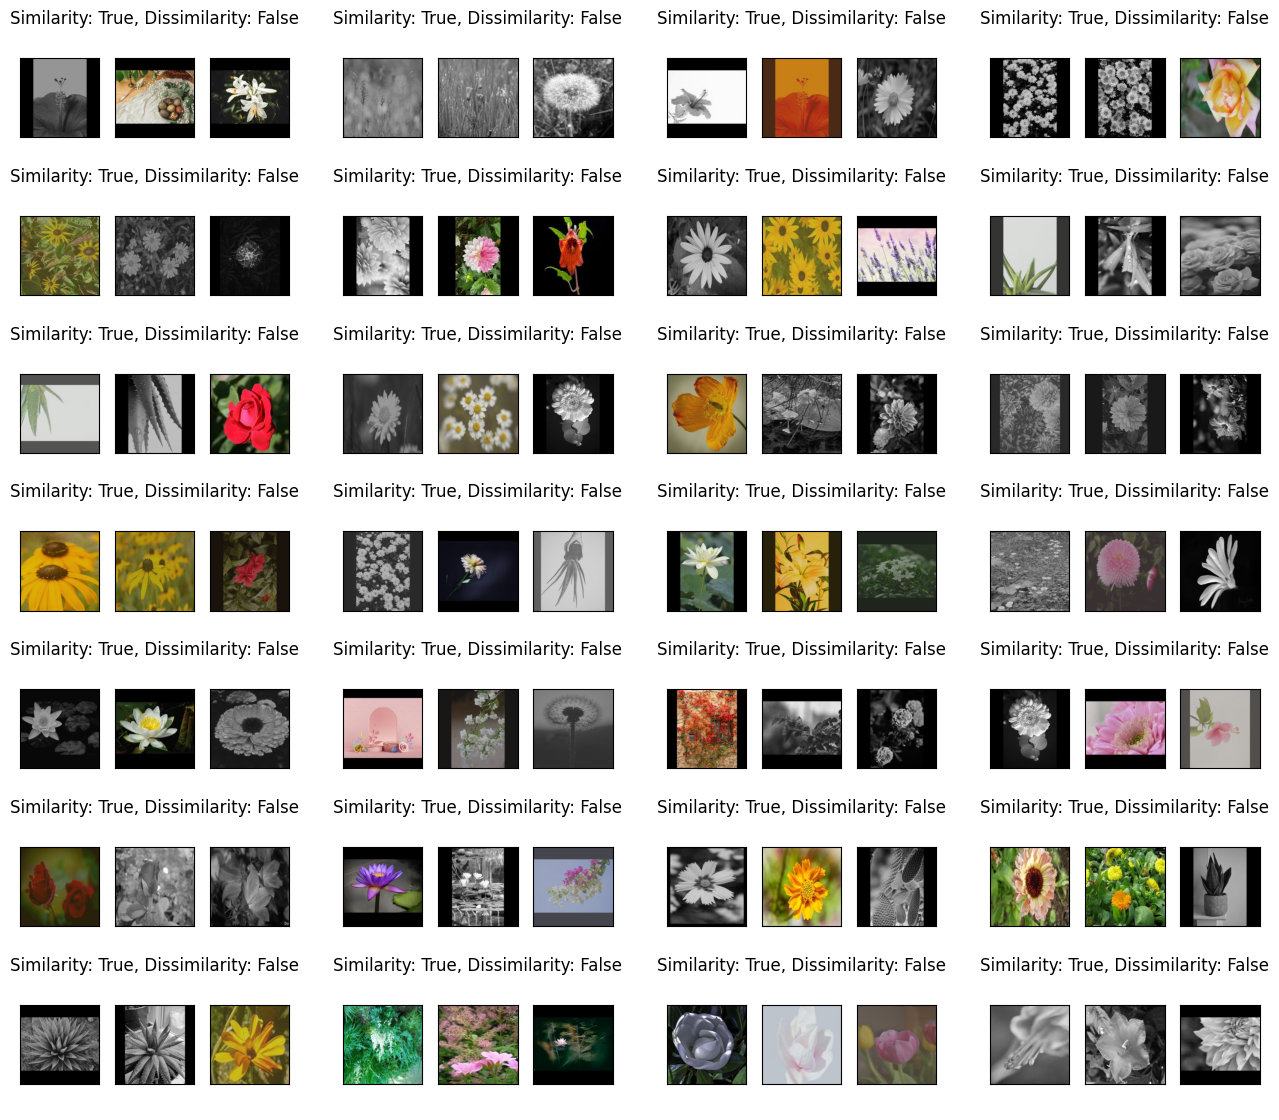

In [8]:
peek_triplet(training_dataset)

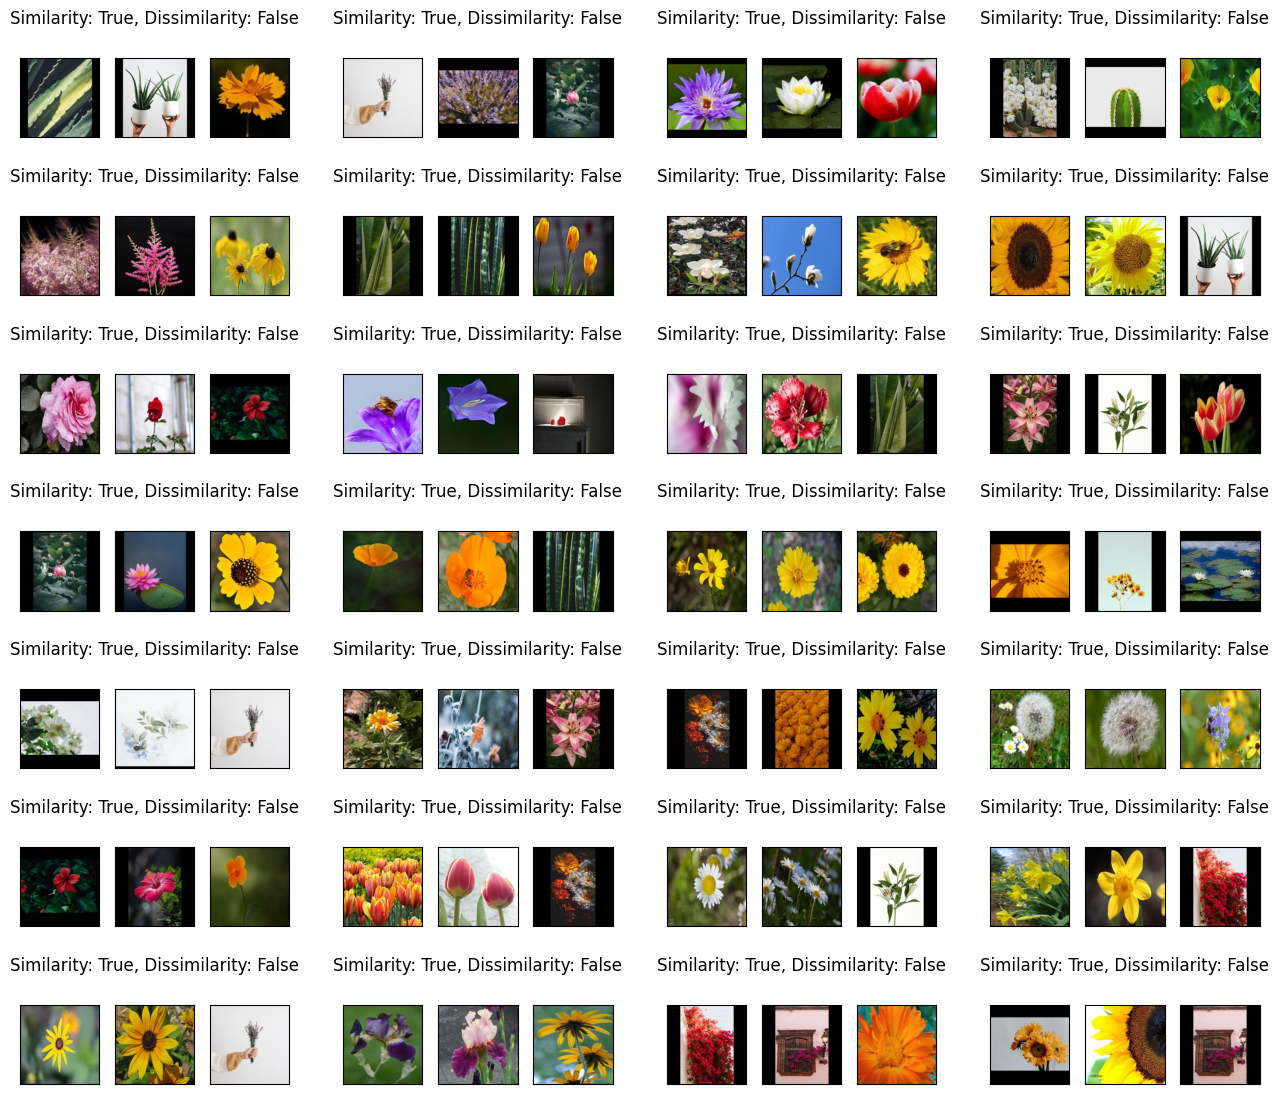

In [9]:
peek_triplet(validation_dataset)

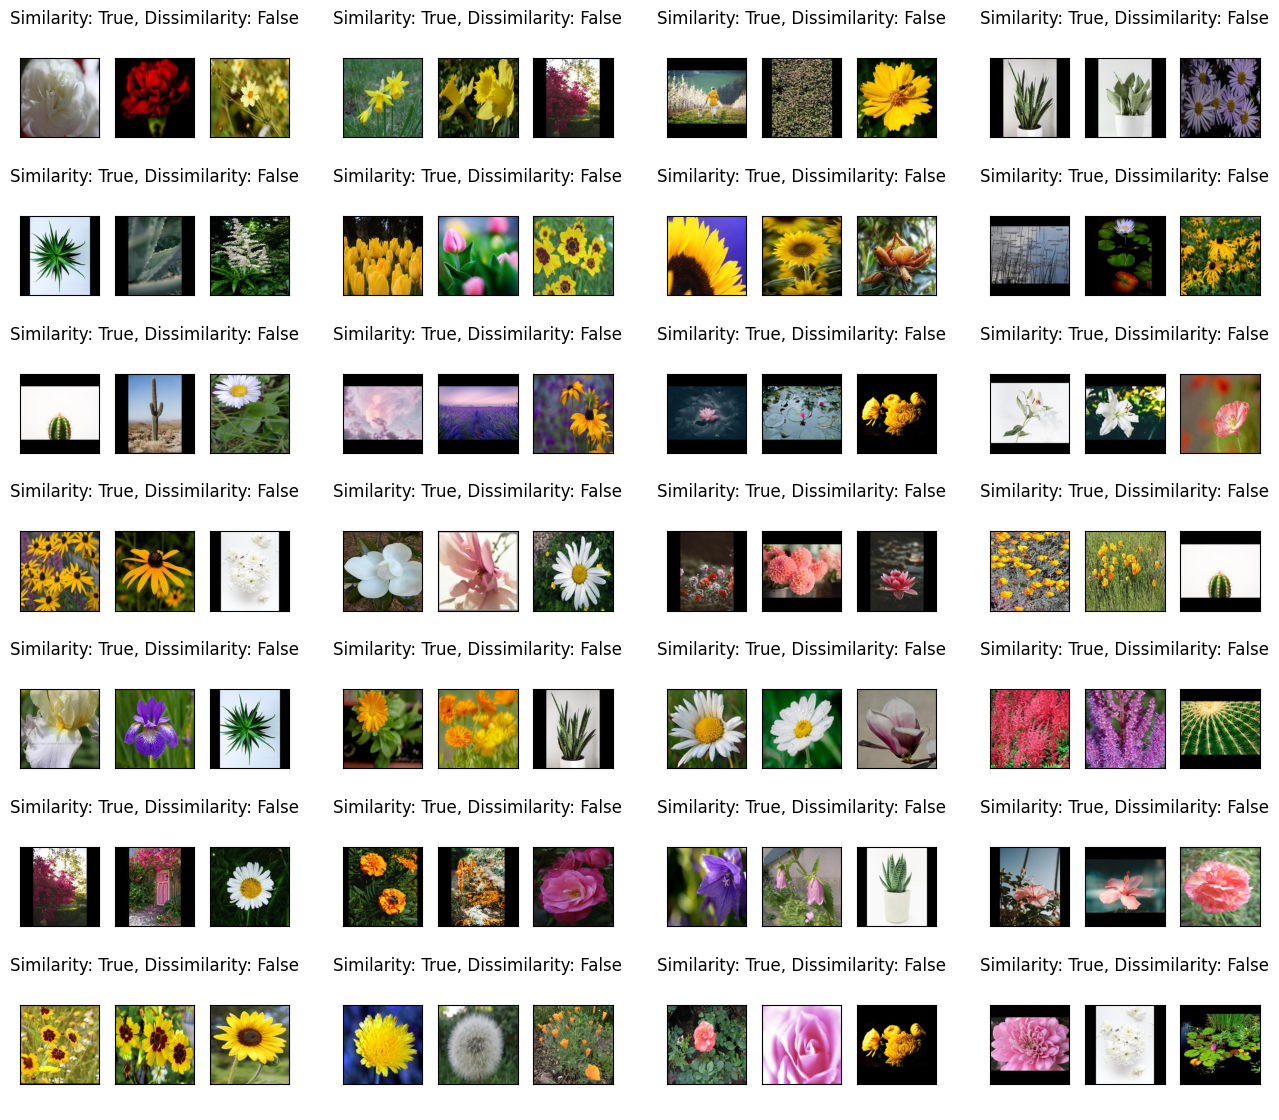

In [10]:
peek_triplet(testing_dataset)

## 3. Build Model


In [11]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks, applications
import tensorflow_hub as hub

class L1_layer(Model):
    def __init__(self, **kwargs):
        super(L1_layer, self).__init__(**kwargs)

    def call(self, tensors):
        x, y = tensors
        distance = tf.math.abs(x - y)
        return distance

In [12]:
def contrastive_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Computes the contrastive loss for Siamese networks.

    Parameters:
    - y_true: True binary labels (0 for dissimilar pairs, 1 for similar pairs).
    - y_pred: Predicted similarity scores from the Siamese network.

    Returns:
    - Contrastive loss value.

    The contrastive loss penalizes dissimilar pairs that are closer than a margin,
    and encourages similar pairs to be within the margin.
    """
    y_pred_positive, y_pred_negative = tf.split(y_pred, 2, axis=-1)

    loss = tf.cast(0, tf.float32)
    for y_true, y_pred in zip([1, 0], [y_pred_positive, y_pred_negative]):
        margin = 1
        y_true = tf.cast(y_true, tf.float32)

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))

        loss += tf.reduce_sum((1 - y_true) * square_pred + y_true * margin_square)
        
    return loss

def triplet_loss(y_true: tf.Tensor, y_pred: tf.Tensor, alpha=0.2)-> tf.Tensor:
    """
    Computes the contrastive loss for Siamese networks.

    Parameters:
    - y_true: True binary labels (0 for dissimilar pairs, 1 for similar pairs).
    - y_pred: Predicted similarity scores from the Siamese network.

    Returns:
    - Contrastive loss value.

    The contrastive loss penalizes dissimilar pairs that are closer than a margin,
    and encourages similar pairs to be within the margin.
    """
    anchor, positive, negative = tf.split(y_pred, 3, axis=1)

    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

    loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + alpha, 0.0))
    return loss


In [13]:
def triplet_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Triplet accuracy metric for Siamese networks.

    Parameters:
    - y_true: true labels (unused in this case, included for compatibility).
    - y_pred: predicted embeddings from the Siamese network.

    Returns:
    - Triplet accuracy.
    """
    anchor, positive, negative = tf.split(y_pred, 3, axis=1)

    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

    accuracy = tf.reduce_mean(tf.cast(pos_dist < neg_dist, tf.float32))
    return accuracy


In [14]:
def build_feature_extractor(build_model=BUILD_MODEL, version=VERSION_TAG, feature_size=1024):
    input_layer = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    feature_extractor = applications.mobilenet_v2.MobileNetV2(
        input_shape=(DIMENSIONS, DIMENSIONS, 3),
        include_top=False,
        weights='imagenet'
    )
    feature_extractor.trainable = True
    # feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    # flatten_layer = layers.Flatten()(feature_extractor)
    feature_extractor = feature_extractor(input_layer, training=True)
    flatten_layer = layers.GlobalAveragePooling2D()(feature_extractor)
    output_layer = layers.Dense(feature_size, activation='sigmoid')(flatten_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name="feature_extractor")

    load_weights = not build_model
    if load_weights:
      model.load_weights(f'{CHECKPOINT_MODEL_PATH}/feature_extractor-weights.{INITIAL_EPOCH:02d}.ckpt')

    return model 

def build_discriminator(build_model=BUILD_MODEL, version=VERSION_TAG, feature_size=1024):
    input_layer_anchor = layers.Input(shape=(feature_size))
    input_layer_comparator = layers.Input(shape=(feature_size))

    distance_layer = L1_layer()([input_layer_anchor, input_layer_comparator])
    dropout_layer = layers.Dropout(0.2)(distance_layer)
    hidden_layer = layers.Dense(8, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

    model = Model([input_layer_anchor, input_layer_comparator], outputs=output_layer, name=f"discriminator")
    
    load_weights = not build_model
    if load_weights:
      model.load_weights(f'{CHECKPOINT_MODEL_PATH}/discriminator-weights.{INITIAL_EPOCH:02d}.ckpt')

    return model


feature_extractor_model = build_feature_extractor()
discriminator_model = build_discriminator()

def build_model():
    input_layer_anchor = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    input_layer_positive = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    input_layer_negative = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))

    anchor_feature_layer = feature_extractor_model(input_layer_anchor)
    positive_feature_layer = feature_extractor_model(input_layer_positive)
    negative_feature_layer = feature_extractor_model(input_layer_negative)

    output_embedding_layer = layers.Concatenate(name="embedding")([anchor_feature_layer, positive_feature_layer, negative_feature_layer])
    
    positive_layer = discriminator_model([anchor_feature_layer, positive_feature_layer])
    negative_layer = discriminator_model([anchor_feature_layer, negative_feature_layer])

    output_similarity_layer = layers.Concatenate(name=f"similarity")([positive_layer, negative_layer])
    
    model = Model(inputs=[input_layer_anchor, input_layer_positive, input_layer_negative], outputs=[output_embedding_layer, output_similarity_layer], name="oneshot-classifier" )

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss={'embedding': triplet_loss, 'similarity': contrastive_loss}, metrics={'embedding': triplet_accuracy})

    return model

model = build_model()

model.summary()




Model: "oneshot-classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 feature_extractor (Functio  (None, 1024)                 3569728   ['input_5[0][0]',             
 nal)                                                                'input_6[

### 4.1 Callbacks

In [15]:
# Define the step decay function
def step_decay(epoch):
    epoch += INITIAL_EPOCH
    if epoch < 50:
        initial_lr = 3e-05
        return initial_lr
    elif epoch < 150:
        initial_lr = 1e-05
        return initial_lr
    elif epoch < 200:
        initial_lr = 3e-06
        return initial_lr
    else:
        initial_lr = 1e-06
        return initial_lr

# Define the learning rate schedule
lr_schedule = callbacks.LearningRateScheduler(step_decay)

class ModelCheckpoint(callbacks.Callback):
    def __init__(self):
        self.save_frequency = 2
        self.save_path = CHECKPOINT_MODEL_PATH+"/{model}-weights.{epoch:02d}.ckpt"

    def on_epoch_end(self, epoch, logs=None):
        epoch += INITIAL_EPOCH + self.save_frequency
        if epoch % self.save_frequency != 0:
            return

        feature_extractor_model.save_weights(self.save_path.format(model="feature_extractor", epoch=epoch))
        discriminator_model.save_weights(self.save_path.format(model="discriminator", epoch=epoch))

        print("\nSaved Model at checkpoint ", epoch)

checkpoint_callback = ModelCheckpoint()

### 4.2 Train Model


In [16]:
%%time

# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[lr_schedule, checkpoint_callback])

Epoch 1/10


     50/Unknown - 193s 3s/step - loss: 5.4265 - embedding_loss: 0.2672 - similarity_loss: 5.1593 - embedding_triplet_accuracy: 0.9571
Saved Model at checkpoint  42
50/50 [==============================] - 277s 5s/step - loss: 5.4265 - embedding_loss: 0.2672 - similarity_loss: 5.1593 - embedding_triplet_accuracy: 0.9571 - val_loss: 8.7718 - val_embedding_loss: 1.1467 - val_similarity_loss: 7.6252 - val_embedding_triplet_accuracy: 0.9064 - lr: 3.0000e-05
Epoch 2/10
50/50 [==============================] - 244s 5s/step - loss: 4.9657 - embedding_loss: 0.2423 - similarity_loss: 4.7234 - embedding_triplet_accuracy: 0.9579 - val_loss: 8.9407 - val_embedding_loss: 1.1458 - val_similarity_loss: 7.7950 - val_embedding_triplet_accuracy: 0.9050 - lr: 3.0000e-05
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 5.2825 - embedding_loss: 0.2701 - similarity_loss: 5.0124 - embedding_triplet_accuracy: 0.9579
Saved Model at checkpoint  44
50/50 [==========================

### 4.3 Training Result



initial | Training loss: 5.4265 | Validation Loss: 8.7718 || Training Accuracy: 95.71 % | Validation Accuracy: 90.64 %
 latest | Training loss: 5.0307 | Validation Loss: 8.7239 || Training Accuracy: 95.64 % | Validation Accuracy: 91.21 %


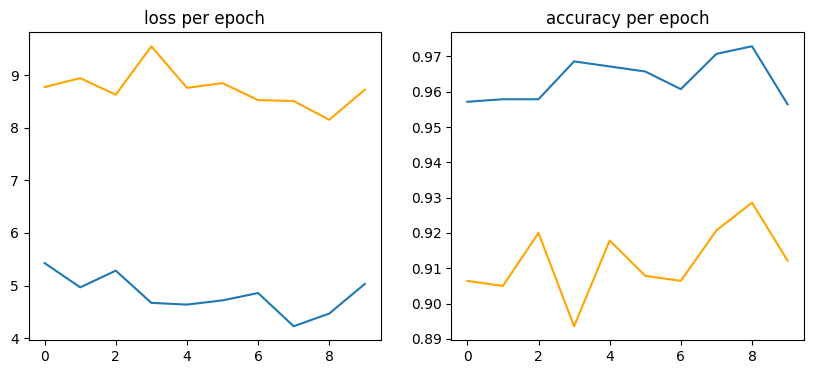

In [17]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][0], history.history["val_loss"][0], history.history["embedding_triplet_accuracy"][0] * 100, history.history["val_embedding_triplet_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][-1], history.history["val_loss"][-1], history.history["embedding_triplet_accuracy"][-1] * 100, history.history["val_embedding_triplet_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["embedding_triplet_accuracy"])
axis[1].plot(history.history["val_embedding_triplet_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

## 5. Test Model


In [16]:
# Evaluate the model
model.evaluate(testing_dataset)

# print('Test loss:', test_loss, 'Test accuracy:', test_acc)



50/50 [==============================] - 108s 2s/step - loss: 7.5546 - embedding_loss: 0.7200 - similarity_loss: 6.8346 - embedding_triplet_accuracy: 0.9171


[7.554609298706055, 0.7199605703353882, 6.834649085998535, 0.9171425700187683]

## 6. Visualize Result


In [17]:
sample_size = 24
grouped_testing_dataset_sampled = {}

for label in grouped_testing_dataset:
	grouped_testing_dataset_sampled[label] = random.sample(grouped_testing_dataset[label], sample_size) if len(grouped_testing_dataset[label]) > sample_size else grouped_testing_dataset[label]

In [18]:
test_images = tf.convert_to_tensor([preprocess_image(item, False) for sublist in grouped_testing_dataset_sampled.values() for item in sublist])
test_labels = tf.cast([key for key in grouped_testing_dataset_sampled.keys() for item in grouped_testing_dataset_sampled[key]], tf.int32).numpy()

features = feature_extractor_model.predict(test_images)

14/14 [==============================] - 11s 686ms/step


In [22]:
""" similarity_matrix = calculate_similarity_matrix(features)

print("Similarity Matrix Shape", similarity_matrix.shape) """

anchor_embeddings = features
anchor_class_labels = test_labels

target_embeddings = tf.expand_dims(anchor_embeddings, axis=1)
target_embeddings = tf.repeat(target_embeddings, repeats=len(anchor_embeddings), axis=1)

anchor_embeddings = tf.repeat(tf.expand_dims(anchor_embeddings, axis=0), repeats=target_embeddings.shape[0], axis=0)

similarities = discriminator_model.predict((tf.reshape(target_embeddings, [-1, target_embeddings.shape[-1]]),
                                            tf.reshape(anchor_embeddings, [-1, anchor_embeddings.shape[-1]])))

similarity_matrix = tf.reshape(similarities, [target_embeddings.shape[0], -1]).numpy()

print("Similarity Matrix Shape:", similarity_matrix.shape)


5832/5832 [==============================] - 10s 2ms/step
Similarity Matrix Shape: (432, 432)


In [23]:
avg_similarity_matrix, avg_test_labels = avg_matrix(similarity_matrix, test_labels)

instance_test_accuracy = oneshot_accuracy(similarity_matrix, test_labels)
test_accuracy = oneshot_accuracy(avg_similarity_matrix, avg_test_labels)

print("Accuracy", instance_test_accuracy, "Class Accuracy", test_accuracy)

Accuracy 0.14814815 Class Accuracy 0.5


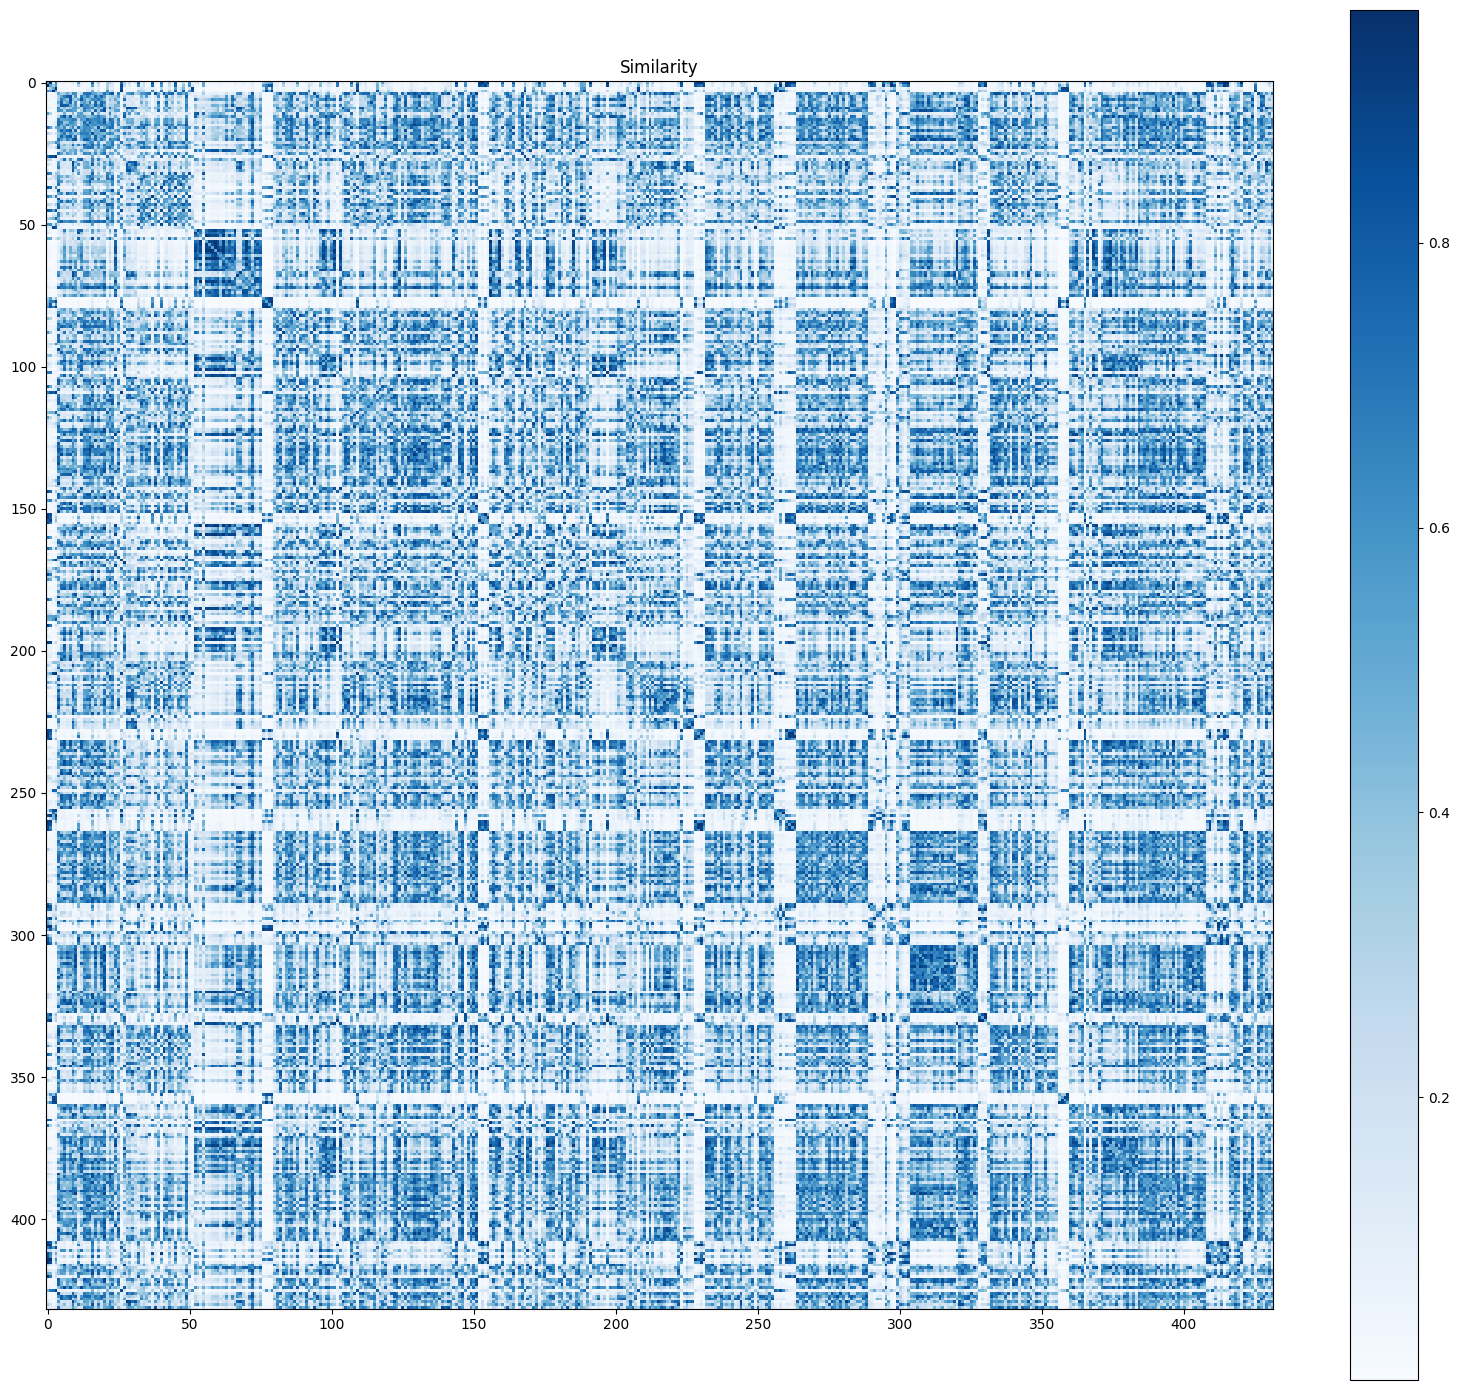

In [24]:
plot_confusion_matrix(similarity_matrix, test_labels, normalize=True, simple=True, title="Similarity")

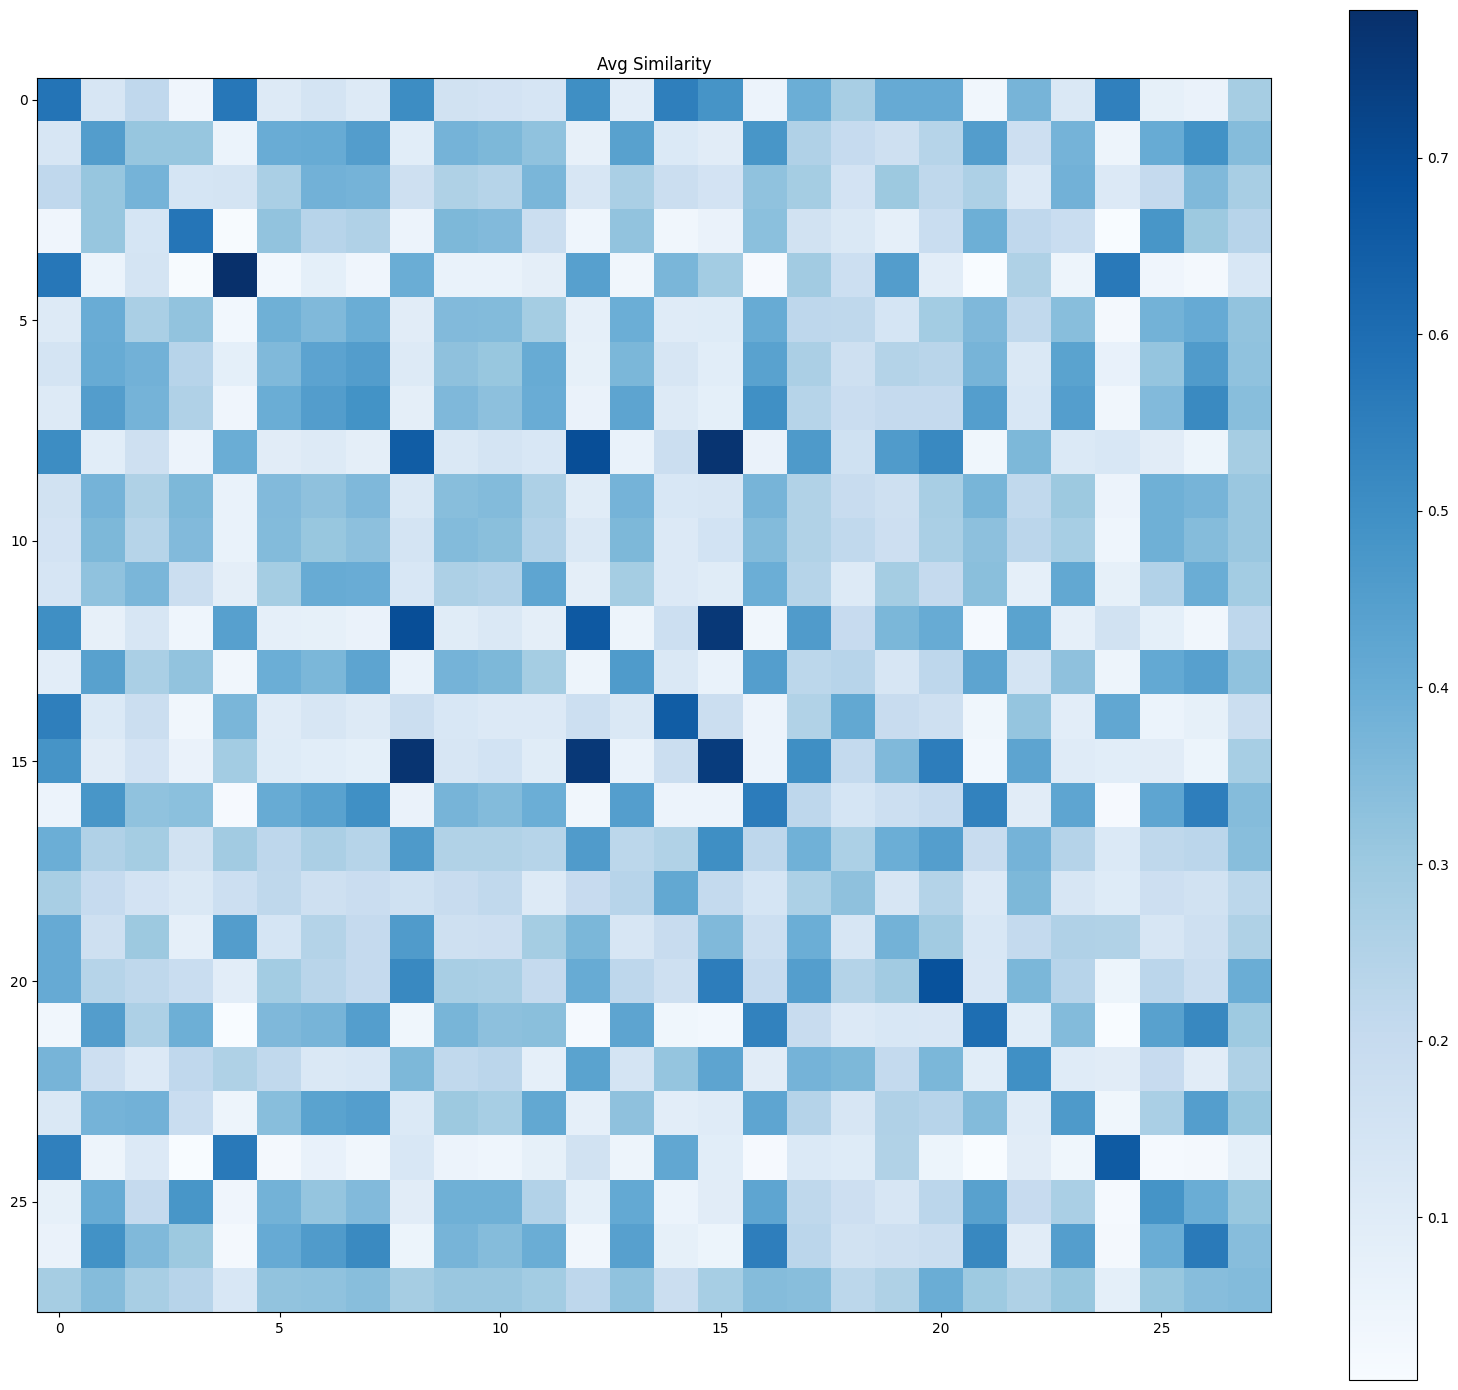

In [25]:
plot_confusion_matrix(avg_similarity_matrix, avg_test_labels, normalize=True, simple=True, title="Avg Similarity")


## 7. Save Model


In [26]:
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + f"-{int(test_accuracy * 100)}"  # "0.0.0"

models.save_model(feature_extractor_model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")
models.save_model(feature_extractor_model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras', save_format="keras")
# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}', save_format="tf")

C:\Users\shirs\AppData\Local\Temp\ipykernel_26504\3108096524.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(feature_extractor_model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")
